This problem is taken from **Analytics Vidhya's** open ***Hackathon contest***.

# **Introduction**

Sentiment analysis is contextual mining of text which identifies and extracts subjective information in source material, and helping a business to understand the social sentiment of their brand, product or service while monitoring online conversations. Brands can use this data to measure the success of their products in an objective manner. In this challenge, you are provided with tweet data to predict sentiment on electronic products of netizens.

# **Problem Statement**

Sentiment analysis remains one of the key problems that has seen extensive application of natural language processing. This time around, given the tweets from customers about various tech firms who manufacture and sell mobiles, computers, laptops, etc, the task is to identify if the tweets have a negative sentiment towards such companies or products.





First, I will import all the necessary **libraries** :

In [0]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer


In [156]:
from google.colab import files
uploaded = files.upload()

Saving train_2kmZucJ.csv to train_2kmZucJ (1).csv


I have put the training data in 'train' dataframe and test data in 'test' dataframe which will only be used for submission

In [0]:
train = pd.read_csv('train_2kmZucJ.csv').drop(columns = ['id'])

In [158]:
train.head()

,label,tweet
0,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,0,Finally a transparant silicon case ^^ Thanks t...
2,0,We love this! Would you go? #talk #makememorie...
3,0,I'm wired I know I'm George I was made that wa...
4,1,What amazing service! Apple won't even talk to...


Clearly, the tweets contain a lot of noisy data which is not useful for aalysing the sentiments of the tweets. Also, the **label 0** corresponds for the tweets that has a **positive** sentiment and **label 1** corresponds to the tweets with the **negative** sentiments.

In [160]:
from google.colab import files
uploaded = files.upload()

Saving test_oJQbWVk.csv to test_oJQbWVk (1).csv


In [0]:
test = pd.read_csv('test_oJQbWVk.csv').drop(columns = ['id'])

In [162]:
test.head()

,tweet
0,I hate the new #iphone upgrade. Won't let me d...
1,currently shitting my fucking pants. #apple #i...
2,"I'd like to puts some CD-ROMS on my iPad, is t..."
3,My ipod is officially dead. I lost all my pict...
4,Been fighting iTunes all night! I only want th...


I will now check the percentage of tweets having positive and negative sentiments.

Percentage of tweets labeled as a negative sentiment 25.58080808080808%
Percentage of tweets labeled as a positive sentiment 74.41919191919192%


Text(0, 0.5, 'Count')

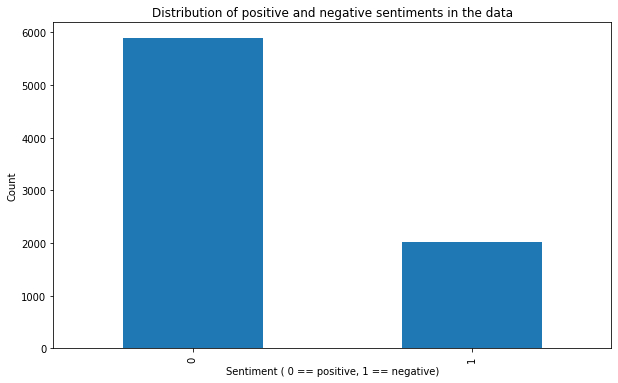

In [163]:
#Printing percentage of tweets with +ve and -ve sentiments

print('Percentage of tweets labeled as a negative sentiment ', end = '')
print(sum(train['label']==1)*100/train.shape[0], end ='%\n')

print('Percentage of tweets labeled as a positive sentiment ', end = '')

print(sum(train['label']==0)*100/train.shape[0], end ='%\n')


ax = train['label'].value_counts().plot(kind='bar',
                                    figsize=(10,6),
                                    title="Distribution of positive and negative sentiments in the data")
ax.set_xlabel("Sentiment ( 0 == positive, 1 == negative)")
ax.set_ylabel("Count")

The bars and the percentage above clealy shows that approximately 75% of the tweets are positive whereas 25% are negative. hence, we can infer that the data is **imbalanced**. Therefore, the problem has asks us to find the best algorithm based on **weighted F1 score**

In [164]:
train.describe()

,label
count,7920.000000
mean,0.255808
std,0.436342
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Now, the first step is to remove the noisy data from the tweets like punctuations, hastags, @ and others which aren't alphanumeric. Only alphanumeric data are meaningful and can thus help us in identifying the sentiments. For this, we will import **RegexpTokenizer** which will split the strings into substrings based on a regular expression. The regular expression I am gonna use is '\w+ which will tokenize all the alphanumeric data and remove all other noises from the tweets.


In [0]:
from nltk.tokenize import RegexpTokenizer
regexp = RegexpTokenizer(r"\w+")

I will apply the RegexpTokenizer in both training and test sets. The preprocessing will be the same for both traing and test set for the model to predict the label.

In [0]:
#applying regexptokenize to both training and test sets
train['tweet']=train['tweet'].apply(regexp.tokenize)
test['tweet']=test['tweet'].apply(regexp.tokenize)

In [167]:
train.head()

,label,tweet
0,0,"[fingerprint, Pregnancy, Test, https, goo, gl,..."
1,0,"[Finally, a, transparant, silicon, case, Thank..."
2,0,"[We, love, this, Would, you, go, talk, makemem..."
3,0,"[I, m, wired, I, know, I, m, George, I, was, m..."
4,1,"[What, amazing, service, Apple, won, t, even, ..."


In [168]:
test.head()

,tweet
0,"[I, hate, the, new, iphone, upgrade, Won, t, l..."
1,"[currently, shitting, my, fucking, pants, appl..."
2,"[I, d, like, to, puts, some, CD, ROMS, on, my,..."
3,"[My, ipod, is, officially, dead, I, lost, all,..."
4,"[Been, fighting, iTunes, all, night, I, only, ..."


Now, the next step is to remove all the common words which aren't useful for sentiment analysis. Words like about, above, punctuations, conjunctions, etc are used a lot in any text data but aren't useful specially for our purpose. These words are called stopwords. I will now remove the stopwords and make our tweets more cleaner for analysis.

In [169]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [170]:
#list of stopwords
list_stop_words = set(stopwords.words('english'))
list_stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [0]:
#remove stopwords from both training and test set
train['tweet'] = train['tweet'].apply(lambda x: [item for item in x if item not in list_stop_words])

test['tweet'] = test['tweet'].apply(lambda x: [item for item in x if item not in list_stop_words])


In [172]:
train.head()

,label,tweet
0,0,"[fingerprint, Pregnancy, Test, https, goo, gl,..."
1,0,"[Finally, transparant, silicon, case, Thanks, ..."
2,0,"[We, love, Would, go, talk, makememories, unpl..."
3,0,"[I, wired, I, know, I, George, I, made, way, i..."
4,1,"[What, amazing, service, Apple, even, talk, qu..."


In [173]:
test.head()

,tweet
0,"[I, hate, new, iphone, upgrade, Won, let, down..."
1,"[currently, shitting, fucking, pants, apple, i..."
2,"[I, like, puts, CD, ROMS, iPad, possible, Yes,..."
3,"[My, ipod, officially, dead, I, lost, pictures..."
4,"[Been, fighting, iTunes, night, I, want, music..."


Now, as a next step, I will remove all the words that are still left and have a length <=2. In general, **small words (length <=2 ) aren't useful** for sentiment analysis. these most probably are noise for our analysis. Therefore, lets remove the small words with length <= 2.

In [0]:
train['tweet'] = train['tweet'].apply(lambda x: ' '.join([w for w in x if len(w)>2]))
test['tweet'] = test['tweet'].apply(lambda x: ' '.join([w for w in x if len(w)>2]))


Now, I will convert all the tweets into smallercase because words like 'apple' or 'Apple' have the same meaning in the sentiment context. If we would't make every word into either lower/upper, our model will consider both as different words. Therefore, lets convert everything into **lowercase**.

In [0]:
train['tweet'] = train['tweet'].str.lower()
test['tweet'] = test['tweet'].str.lower()


Now, I will build a **worldcloud** to have a view of the most frequently occuring words in the whole dataset.

In [176]:
#nltk.download('punkt')
from wordcloud import WordCloud
all_words = ''.join([word for word in train['tweet']])
#printing some
all_words[0:500]

'fingerprint pregnancy test https goo h1mfqv android apps beautiful cute health igers iphoneonly iphonesia iphonefinally transparant silicon case thanks uncle yay sony xperia sonyexperias http instagram com yget5jc6jmlove would talk makememories unplug relax iphone smartphone wifi connect http 6n3lsupcuwired know george made way iphone cute daventry home http instagr li_5_ujs4kwhat amazing service apple even talk question unless pay stupid supportiphone software update fucked phone big time stupi'

In [177]:
len(all_words.split())

105410

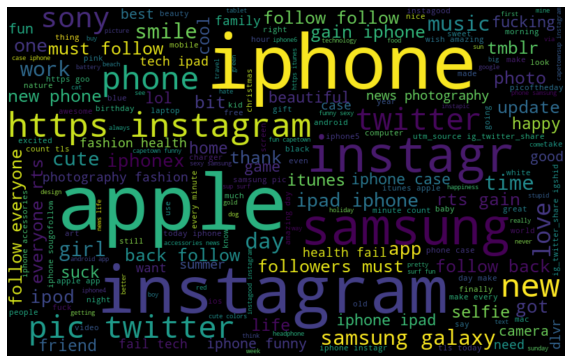

In [178]:
#building a wordcloud on the data from all tweets

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


From the wordcloud, I can see that there are still some words which are useless for my analysis like 'https'. Therefore i am gonna remove them. 

In [0]:
train['tweet'] = train['tweet'].apply(lambda x: x.replace('https',''))
test['tweet'] = test['tweet'].apply(lambda x: x.replace('https',''))

Now, the next step is doing a stemming or lemmatization on all the tokens. Stemming and Lemmatization are Text Normalization (or sometimes called Word Normalization) techniques in the field of Natural Language Processing that are used to prepare text, words, and documents for further processing. This is done to make words wtih similar root and context same which makes it easier for classification algorithms. Like for eg, play, playing and played all mean the same but are different words. If we don't normalize all to a common word play, it makes it difficult for any model to classify the data.

The main difference between stemming and Lemmatization is that stemming works by cutting off the end or a beginning of a word whereas lemmatization works by changing the word to a root word that is meaningful taking into consideration the morphological analysis of words using a vast set of words from '**WordNet**'.

For my purpose, I will use lemmatization as it brings in comon words that are meaningful and thus will be better for our problem.

In [180]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
wordnet_tokenizer = WordNetLemmatizer()
train['tweet'] = train['tweet'].apply(wordnet_tokenizer.lemmatize)
test['tweet'] = test['tweet'].apply(wordnet_tokenizer.lemmatize)

train.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,label,tweet
0,0,fingerprint pregnancy test goo h1mfqv android...
1,0,finally transparant silicon case thanks uncle ...
2,0,love would talk makememories unplug relax ipho...
3,0,wired know george made way iphone cute daventr...
4,1,what amazing service apple even talk question ...


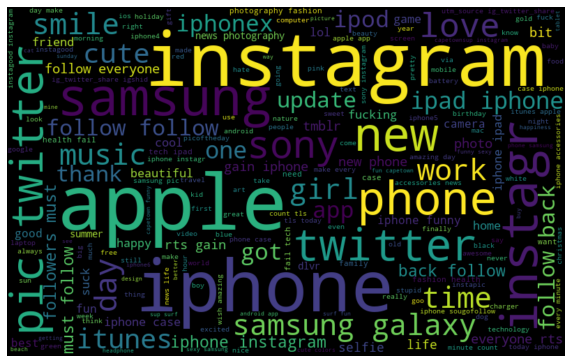

In [181]:
#building wordcloud after lemmatization
from wordcloud import WordCloud
all_words = ''.join([word for word in train['tweet']])
all_words
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Now, I will analyze the **top 20 words (based on frequency)** for positive and negative tweets to have a brief view of words that are mostly in the different types of tweets.

In [182]:
pos = train[train['label'] == 0]
neg = train[train['label'] == 1]
pos_sentiment_words = ''.join([word for word in pos['tweet']])   #words from the tweets that are positive
neg_sentiment_words = ''.join([word for word in neg['tweet']])   ##words from the tweets that are negative
#printing some
neg_sentiment_words[0:300]


'what amazing service apple even talk question unless pay stupid supportiphone software update fucked phone big time stupid iphoneshey apple make new ipod dont make new color 2inches thinner make crash every five fuckin minitenot heavy machinery need apple really dropped ball design drinkyourhaterade'

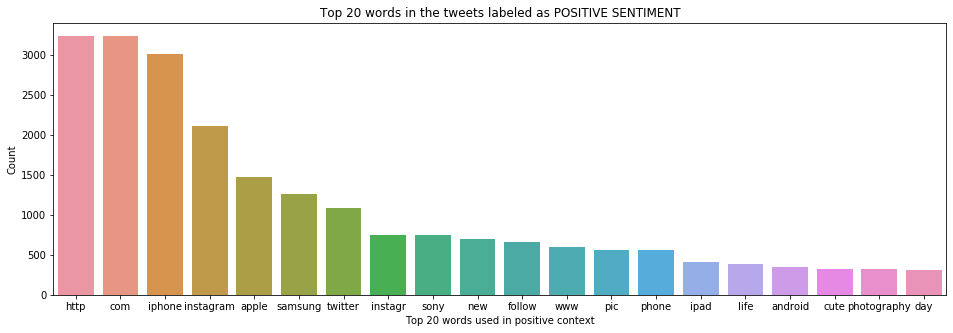

In [183]:
#top 20 words on positive tweets

list_pos_words = [ x for x in pos_sentiment_words.split()]   #list of positive sentiment words
freq_dis_pos = nltk.FreqDist(list_pos_words)   #number of occurances of each word
freq_dataframe = pd.DataFrame({'Words': list(freq_dis_pos.keys()), 'Count': list(freq_dis_pos.values())})  #data frame of words and count
# selecting top 20 most frequent hashtags
freq_dataframe = freq_dataframe.nlargest(columns="Count", n = 20)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=freq_dataframe, x= "Words", y = "Count")
ax.set(ylabel = 'Count')
ax.set(xlabel = 'Top 20 words used in positive context')
plt.title("Top 20 words in the tweets labeled as POSITIVE SENTIMENT")
plt.show()

Some of the words used in positive tweets are life, day, photography, sony, instagram, etc

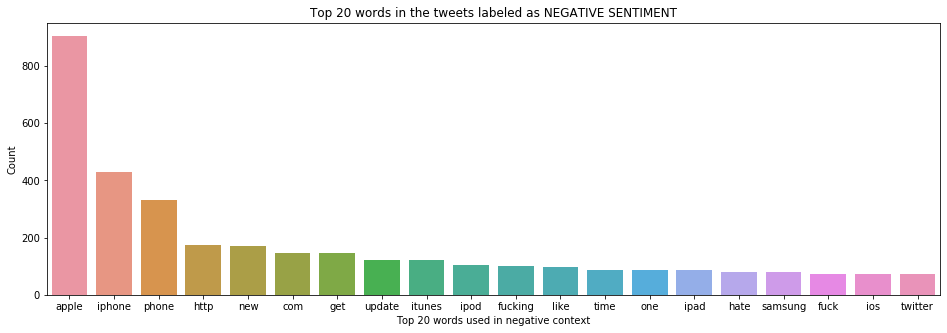

In [184]:
#top 20 words on negative tweets

list_neg_words = [ x for x in neg_sentiment_words.split()]   #list of positive sentiment words
freq_dis_pos = nltk.FreqDist(list_neg_words)   #number of occurances of each word
freq_dataframe = pd.DataFrame({'Words': list(freq_dis_pos.keys()), 'Count': list(freq_dis_pos.values())})  #data frame of words and count
# selecting top 20 most frequent hashtags
freq_dataframe = freq_dataframe.nlargest(columns="Count", n = 20)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=freq_dataframe, x= "Words", y = "Count")
ax.set(ylabel = 'Count')
ax.set(xlabel = 'Top 20 words used in negative context')
plt.title("Top 20 words in the tweets labeled as NEGATIVE SENTIMENT")

plt.show()

Some of the words in the negative tweets are fuck, fucking, ipod, time, etc

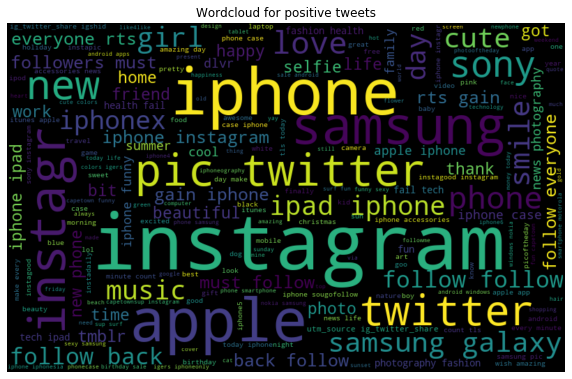

In [185]:
#WordCloud for positive tweets
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_sentiment_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Wordcloud for positive tweets')
plt.show()

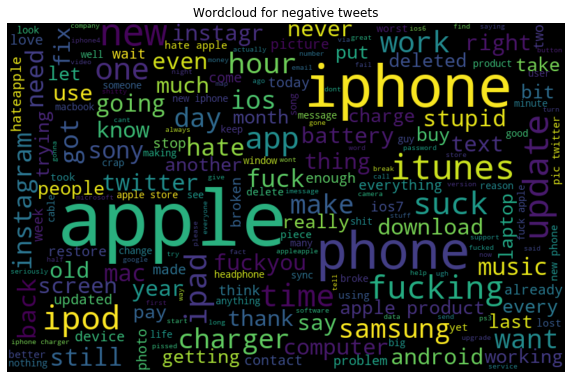

In [186]:
#wordcloud for negative tweets

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_sentiment_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Wordcloud for negative tweets')

plt.show()

Now, that I gained a brief view of the tweets, I will now prepare my data for modelling. Preparation of text data involves converting the text data ito some numerical format which the machine learning models can understand. The computers only understand numerical data, therefore I have to convert the claned tweets into some numeric form. 

Generally there are various ways to prepare text data for modelling like CountVectorizer, TfIdf, etc. **Count Vectorizer** which is based on bag of words model just works by counting the word frequency in each document ( each tweet in this case)

With **TfIdf**, the values increases with the increase in the count of the words but if also offset by the occurence of the same word in different corpus. This is if there is a word 'apple' with high frequency and is present in 80% of the tweets, count vectorizer will give a high value for apple but tfidf will almost neglect it since it occurs sin many documents and therefore isn't a useful word to classify the documents ( tweets here )

In this case, I am gonna use **TfIdf** because it is a better version and will give lower value to the words occuring in many tweets. 

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df = 2, max_df = .9, max_features = 1000, ngram_range = (1, 1))
tfidf_fit = tfidf_vectorizer.fit(train['tweet'])
tfidf = tfidf_fit.transform(train['tweet'])
tfidf_test = tfidf_fit.transform(test['tweet'])

In [84]:
X_train, X_test, y_train, y_test = train_test_split(tfidf, train['label'], random_state = 4, test_size = .3)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(type(X_train))
print(type(X_test))
print(type(y_train))
print(type(y_test))

#converting sparse matrices to np.array

X_train = X_train.toarray()
X_test = X_test.toarray()
y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)
print(type(X_train))
print(type(X_test))
print(type(y_train))
print(type(y_test))
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5544, 1000)
(2376, 1000)
(5544,)
(2376,)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(5544, 1000)
(2376, 1000)
(5544, 1)
(2376, 1)


Now, I will try three models - **Logistic Regression** ( with hyperparameters tuning ), Support Vector Machine ( SVM ) and Naive Bayes Classifier's **MultinomialNB** and look for the best model that we can use for our test set.

In [89]:
#Logistic Regression with GridSearch

clf = LogisticRegression()

# use a full grid over all parameters
param_grid = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
f1 = make_scorer(f1_score , average='weighted')
# run grid search
grid = GridSearchCV(clf, cv=5,scoring=f1, param_grid=param_grid)

grid.fit(X_train, y_train)
print("Grid-Search with roc_auc")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (f1)): {:.3f}".format(grid.best_score_))


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-

Grid-Search with roc_auc
Best parameters: {'C': 1.0, 'penalty': 'l1'}
Best cross-validation score (f1)): 0.880


In [93]:
y_predict = grid.predict(X_test)
print('The weighted F1 score with the best hyperparameters is ', end = '')
print(f1_score(y_test, y_predict, average='weighted'))

print ("Classification Report: ")
print (classification_report(y_test, y_predict))

The weighted F1 score with the best hyperparameters is 0.8900039886903115
Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1783
           1       0.79      0.77      0.78       593

    accuracy                           0.89      2376
   macro avg       0.86      0.85      0.85      2376
weighted avg       0.89      0.89      0.89      2376



The logistic regression with the best hyperparameters give as a **weighted F1 score of 0.89** which seems good enough.

In [100]:
# Classifier - Algorithm - Support Vector Classifier

SVM = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train,y_train)
# predict the labels on validation dataset
y_predict = SVM.predict(X_test)
# Use accuracy_score function to get the accuracy
print('The weighted F1 score ', end = '')

print(f1_score(y_test, y_predict,average='weighted'))
print ("Classification Report: ")
print (classification_report(y_test, y_predict))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The weighted F1 score 0.8916763192504547
Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1783
           1       0.77      0.80      0.79       593

    accuracy                           0.89      2376
   macro avg       0.85      0.86      0.86      2376
weighted avg       0.89      0.89      0.89      2376



The Support Vector Classifier gives as a **weighted F1 score of 0.8916** .

In [106]:
clf = MultinomialNB()

# use a full grid over all parameters
param_grid = {'alpha':[0,1] }
f1 = make_scorer(f1_score , average='weighted')
# run grid search
grid = GridSearchCV(clf, cv=5,scoring=f1, param_grid=param_grid)

grid.fit(X_train, y_train)
print("Grid-Search with roc_auc")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (f1)): {:.3f}".format(grid.best_score_))


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A c

Grid-Search with roc_auc
Best parameters: {'alpha': 1}
Best cross-validation score (f1)): 0.878


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [107]:
y_predict = grid.predict(X_test)
print('The weighted F1 score with the best hyperparameters is ', end = '')
print(f1_score(y_test, y_predict, average='weighted'))

print ("Classification Report: ")
print (classification_report(y_test, y_predict))

The weighted F1 score with the best hyperparameters is 0.8918045395000109
Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1783
           1       0.78      0.78      0.78       593

    accuracy                           0.89      2376
   macro avg       0.86      0.86      0.86      2376
weighted avg       0.89      0.89      0.89      2376



The Naive Bayes Classifier give as a **weighted F1 score of 0.8918** which is in fact the best among all three classifiers. one more positive thing about Naive Bayes Classifier is that it is very fast and efficient algorithm when it comes to computations>

Now, that I have got the best model, I will use the **model on the preprocessed test data** which is stored as tfidf_test

In [0]:
tfidf_test
sparse_test = tfidf_test


In [111]:
#storing preprocessed test data into a array

test_data = sparse_test.toarray()
print(test_data.shape)

(1953, 1000)


In [0]:
#doing predictions using the best algorithm whicch was Naive Bayes in this case

y_predict = grid.predict(test_data)

In [114]:
y_predict.shape

(1953,)

In [116]:
test_dataframe = pd.DataFrame(y_predict)
test_dataframe

,0
0,1
1,0
2,0
3,1
4,1
...,...
1948,0
1949,0
1950,1
1951,1


In [117]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [0]:
test_dataframe.to_csv('sentiment_test.csv')

In [0]:
!cp sentiment_test.csv drive/My\ Drive/